# Ant Rules

1. Ants can only move left or right when traversing forward or backward. For example, if an ant is moving North-East, it can only move to blocks directly north or directly east.

1. Ants lay pheromones when leaving the nest and returning to the nest with food
 1. The ants do not lay pheromones when not moving
 1. The ants lay more pheromones when returning with food versus foraging. The paper indicates 10x as much pheromone.
 
1. There is a maximum number of ants that can occupy a single point. 
 1. If an ant can't move to any valid location, it must remain in it's current location. 
 1. Will's rule: There is no occupancy limit for points in the nest.
 
1. For every step, a percentage of pheromone evaporates from each point.

1. Ants will choose their next location based on the amount of pheromone at each point.
 1. Ants can choose not to move if there is not enough pheromone in front of them (sigmoid relationship).

1. Will's Rule: If an ant finds food it switches direction (NE -> SW, etc)

1. Will's Rule: When ants return home, there is a large probability that they remain home.
 1. Instead of creating all of the agents at once, the authors decided that a fixed amount of ants will be created and leave the nest at each time step. The rule above mimics this rule by only letting out a small percentage of ants at the beginning and avoids the problem of trying to dynamically make/remove agents.
 
# To Do

1. See note about rule 7. We should try a model that constantly outputs a fixed amount of agents from the nest. The number of ants created every step should stop after ants return with food and leave to get more food.

1. Extension(s)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import basename, exists
import random
from scipy.special import expit

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

from utils import decorate, savefig
from scipy.signal import correlate2d

from Cell2D import Cell2D, draw_array

In [21]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

def make_visible_locs(direction):
    """Computes the kernel of visible cells.
        
    direction: ant facing direction
    """
    if direction == "SE":
        return np.array([[-1, 0], [0, 1]])
    elif direction == "SW":
        return np.array([[-1, 0], [0, -1]])
    elif direction == "NW":
        return np.array([[1, 0], [0, -1]])
    else:
        return np.array([[1,0], [0,1]])
    
def flip_directions(direction):
    if direction == "NE":
        return "SW"
    elif direction == "NW":
        return "SE"
    elif direction == "SW":
        return "NE"
    else:
        return "NW"

In [35]:
np.random.rand()

0.7530678860598654

In [127]:
class Antscape(Cell2D):
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        
        #parameters
        self.ant_per_cell_max = self.params.get('max_ants', 1)
        self.sigmoid_offset = self.params.get('sigmoid_offset', 1)
        
        # initially all cells are empty
        self.array = self.make_env()
        
        # pheromone array
        self.parray = np.ones([n,n])
        
        # make the agents
        self.make_agents()
        
    
    def make_env(self):
        """
        TODO: This isn't a great solution. Needs to be more elegant.
        
        square with food >= 1
        square with nest = -1
        """
        array = np.zeros([self.n, self.n])
        
        # make food
        for i in range(self.n):
            for j in range(self.n):
                if np.random.rand() >= .99:
                    array[i,j] = 200
                
        #make nest
        nh, nw = 20,20
        for i in range(nh):
            for j in range(nw):
                array[i, j] = -1
                
        for i in range(40):
            array[0,i] = -1
            array[i,0] = -1
                
        return array

        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        loc = (0,0)

        # make the agents
        num_agents = self.params.get('num_agents', 20)
        loc = self.params.get('starting_loc', (0,0))
        self.agents = [Agent(loc, self.params) 
                       for i in range(num_agents)]
        
        # keep track of which cells are occupied
        self.occupied = [agent.loc for agent in self.agents]
            
    def find_food(self, center):
        
        if self.array[center] > 0:
            self.array[center] -= 1
            return True
        else:
            return False
    
    def find_nest(self, center):
        return self.array[center] == -1
        
    def p_deposit(self, center, p):
        """
        TODO: parameterize pheromone limit
        """
        self.parray[center] += p
        
        if self.parray[center] > 100:
            self.parray[center] = 100
            
    def look_and_move(self, center, direction):
        """
        Finds available locations for agent, picks a location based on pheromone weights,
        decides whether agent moves based on a sigmoid function.
        """
        
        # find all cells ant can move to and deals with edge cases
        locs = make_visible_locs(direction)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        #calc number of ants in each a cell
        num_ants = {}
        for loc in locs:
            count = 0
            for xy in self.occupied:
                if xy == loc:
                    count += 1
            num_ants[loc] = count
        
        # select cells that are not too full or that are part of the nest
        empty_locs = [loc for loc in locs if (num_ants[loc] < self.ant_per_cell_max) or self.array[loc] == 2]

        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the pheromone level in each cell
        p_levels = [self.parray[loc] for loc in empty_locs]
        
        new_loc = random.choices(empty_locs, weights=p_levels)[0]
        
        # decide whether to move to new location
        move_prob = expit(self.parray[new_loc] - self.sigmoid_offset)
        
        if np.random.choice([True, False], p=[move_prob, 1 - move_prob]):
            return new_loc
        else:
            return center
            
        
    def step(self):
        """Executes one time step."""
        
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        
        #decrease pheromone levels
        self.parray *= .98
        self.parray[self.parray < 1] = 1
#         self.parray += .01
        
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            # execute one step
            agent.step(self)
            
            #mark fly's new cell as occupied
            self.occupied.append(agent.loc)
        
        return len(self.agents)
    
    def draw(self):
        """Draws the cells."""
        plt.figure(figsize=(10,8))
        plt.subplot(1,2,1)
        draw_array(self.parray, cmap='Purples', vmax=10, origin='lower')
        plt.subplot(1,2,2)
        draw_array(self.array, cmap='Blues', vmax=3, origin='lower')
        
        
        # draw occupied cells
        xs, ys = self.get_coords(self.occupied)
        self.points = plt.plot(xs, ys, '.', color='black')[0]
    
    def get_coords(self, locs):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        locs = list(locs)
        rows, cols = np.transpose(locs)
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

In [128]:
class Agent:
    
    def __init__(self, loc, params):

        self.loc = tuple(loc)
        self.has_food = False
        self.is_home = True
        self.direction = "NE"
        self.p_foraging  = 1
        self.p_returning = 20
    

    def step(self, env):
        
        old_loc = self.loc
        
        #look for food
        if env.find_food(self.loc) and not self.has_food:
            self.direction = flip_directions(self.direction)
            self.has_food = True
        
        #look for nest
        if env.find_nest(self.loc):
            if not self.is_home and self.has_food:
                self.direction = flip_directions(self.direction)
                self.has_food = False
                self.is_home = True
        else:
            self.is_home = False
        
        #move agent if it doesn't want to stay home
        if not self.is_home or np.random.choice([False, True], p=[.997, .003]):
            self.loc = env.look_and_move(self.loc, self.direction)
        
        #lay pheremone (only if you move)
        if old_loc != self.loc:
            if self.has_food:
                p = self.p_returning
            else:
                p = self.p_foraging
                
            env.p_deposit(self.loc, p)
                                                      



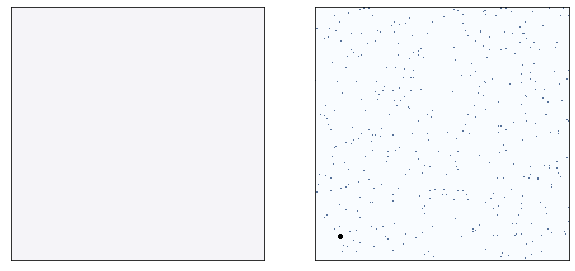

In [131]:
env = Antscape(200, num_agents=500, max_ants=20, starting_loc=(19,19), sigmoid_offset=3.5)


env.step()
env.draw()

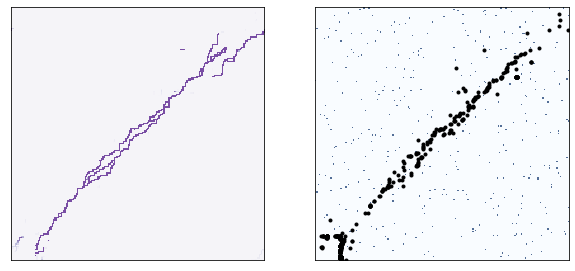

In [136]:
env.animate(frames=500)

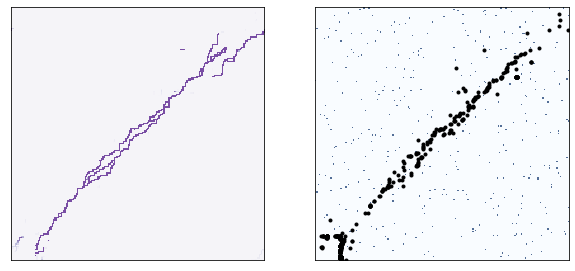

In [137]:
env.draw()
plt.savefig("scattered_run_1000.png")